<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [ ]:
!pip install torchtext==0.9.1

In [2]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque, Counter
from nltk.corpus import brown
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [3]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Существует множество наборов грамматических тегов, или тегсетов, например:
* НКРЯ
* Mystem
* UPenn
* OpenCorpora (его использует pymorphy2)
* Universal Dependencies

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На данный момент стандартом является **Universal Dependencies**. Подробнее про проект можно почитать [вот тут](http://universaldependencies.org/), а про теги — [вот тут](http://universaldependencies.org/u/pos/)

In [4]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


Мы имеем массив предложений пар (слово-тег)

In [5]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [ ]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [6]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [7]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [8]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False) # тег - кол-во тега в корпусе
word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


In [ ]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

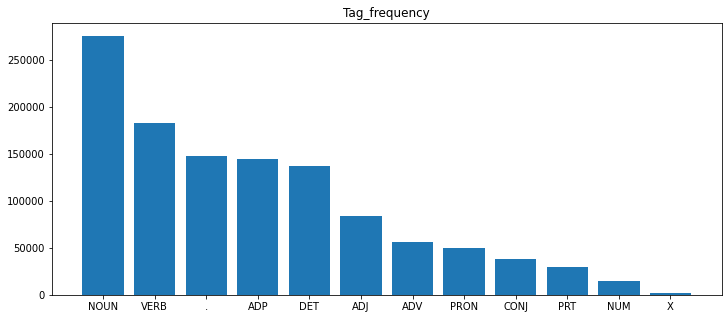

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [ ]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

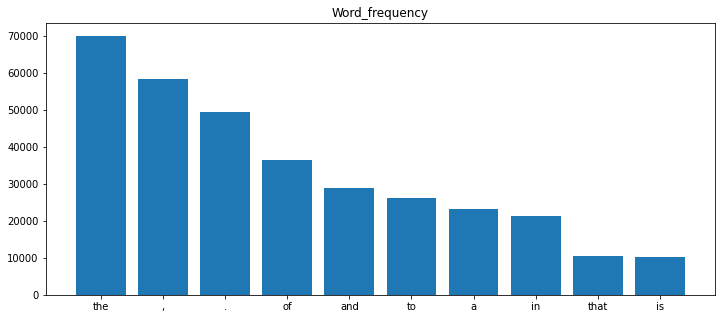

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?

In [ ]:
nltk.FreqDist(['cat'])

FreqDist({'cat': 1})

### Вопрос 2:
* Самое популярное слово с самым популярным тегом? <br>(*сначала выбираете слова с самым популярным тегом, а затем выбираете самое популярное слово из уже выбранных*)

In [ ]:
pd.Series(nltk.FreqDist([pair[0] for pair in brown_tagged_words if pair[1] == 'NOUN'])).sort_values(ascending=False).index[0]

'time'

Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [ ]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [9]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=0.3, random_state=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
len(train_sents)

737

In [ ]:
len(test_sents)

316

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамического программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [10]:
class HiddenMarkovModel:    
    def __init__(self):
        pass
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]
        
        tag_freq = Counter(tags)
        word_freq = Counter(words)
        tag_num = pd.Series(tag_freq).sort_index()
        word_num = pd.Series(word_freq).sort_values(ascending=False)


        most_popular_tag = tag_freq.most_common(1)[0][0]
        words_freq_with_most_popular_tag = Counter(
                word for sent in train_tokens_tags_list
                for word, tag in sent if tag == most_popular_tag)
        most_popular_word_with_most_popular_tag = words_freq_with_most_popular_tag.most_common(1)[0][0]
        self._plug = most_popular_word_with_most_popular_tag

        tag_num = pd.Series(nltk.FreqDist(tags)).sort_index()
        word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)
         
        self.tags = tag_num.index
        self.words = word_num.index
        
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов

        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B
        
        return self
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = test_tokens_list[i_sent] # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros_like(q) # # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = self._plug
                
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    
                    s = self.tags[i_s]
                    
                    # формула (1)
                    q[t + 1][i_s] = np.max(q[t] *
                        self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s])

                    # argmax формула(1)
                    # argmax, чтобы восстановить последовательность тегов

                    back_point[t + 1][i_s] = (q[t] * self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s]).rename(0).reset_index()[0].idxmax() # индекс 

            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
            
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags                 

Обучите скрытую марковскую модель:

In [11]:
my_model = HiddenMarkovModel()
my_model = my_model.fit(train_sents)

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [82]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
my_model.predict(sents)

OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

### Вопрос 3:
* Какой тег вы получили для слова `can`?

In [ ]:
'VERB'

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?

In [ ]:
'NOUN'

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [27]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in tqdm(sents):
        tags = [tag for (word, tag) in sent]
        words = [word for (word, tag) in sent]

        predict = model.predict([words])[0]

        true_pred += np.sum(predict == tags)
        num_pred += len(predict)
    print("Accuracy:", true_pred / num_pred * 100, '%')

In [84]:
accuracy_score(my_model, test_sents)

100%|██████████| 316/316 [03:21<00:00,  1.56it/s]

Accuracy: 87.30822873082286 %


### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?

In [ ]:
Accuracy: 87.3 %

## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения)

In [85]:
from nltk.tag import DefaultTagger

default_tagger = DefaultTagger('NOUN')

In [86]:
class TaggerModel:
    def __init__(self, tagger):
        self._tagger = tagger

    def predict(self, test_tokens_list):

        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
  
        for i, sent in enumerate(self._tagger.tag_sents(test_tokens_list)):
            predict_tags[i] = np.array([tag for word, tag in sent])
        return predict_tags

model = TaggerModel(default_tagger)

In [87]:
accuracy_score(model, test_sents)

100%|██████████| 316/316 [00:00<00:00, 15242.72it/s]

Accuracy: 20.238648690531534 %


In [ ]:
Accuracy: 20.238648690531534 %

## NLTK, Rnnmorph

Вспомним первый [семинар](https://colab.research.google.com/drive/1FHZVU6yJT61J8w1hALno0stD4VU36rit?usp=sharing) нашего курса. В том семинаре мы с вами работали c некоторыми библиотеками.

Не забудьте преобразовать систему тэгов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [ ]:
!pip install rnnmorph

In [88]:
from rnnmorph.predictor import RNNMorphPredictor
from nltk.tag.mapping import map_tag
import warnings

In [89]:
how_many = None
test_words = [[word for word, _ in sent] for sent in test_sents[:how_many]]
test_tags = [[tag for _, tag in sent] for sent in test_sents[:how_many]]

In [90]:
nltk.download('averaged_perceptron_tagger')

nltk_results = [[tag for _, tag in sent] for sent in nltk.pos_tag_sents(test_words, tagset='universal')]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [91]:
predictor = RNNMorphPredictor(language="en")

rnnmorph_results = [[form.pos for form in sent] for sent in predictor.predict_sentences(test_words)]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [92]:
warnings.filterwarnings("ignore", module="tensorflow", category=DeprecationWarning)

### Вопрос 7:
* Какое качество вы получили, используя каждую из двух библиотек? Сравните их результаты.

* Качество с библиотекой rnnmorph должно быть хуже, так как там используется немного другая система тэгов. Какие здесь отличия?

In [11]:
import numpy as np

def accuracy(true_tags, predicted_tags):
    if len(true_tags) != len(predicted_tags):
        raise ValueError("numbers of sentences are not equal")
    total = true = 0
    for true_tags_sent, predicted_tags_sent in zip(true_tags, predicted_tags):
        if len(true_tags_sent) != len(predicted_tags_sent):
            raise ValueError("lenghts of sentences are not equal")
        if not isinstance(true_tags_sent, np.ndarray):
            true_tags_sent = np.array(true_tags_sent)
        if not isinstance(predicted_tags_sent, np.ndarray):
            predicted_tags_sent = np.array(predicted_tags_sent)
        total += len(true_tags_sent)
        true += np.sum(true_tags_sent == predicted_tags_sent)
    return true / total * 100

In [ ]:
print(f"Accuracy with nltk: {accuracy(test_tags, nltk_results):.3f}%")
print(f"Accuracy with rnnmorph: {accuracy(test_tags, rnnmorph_results):.3f}%")

Accuracy with nltk: 89.152%
Accuracy with rnnmorph: 64.032%


На просторах интернета нашел руководство (https://universaldependencies.org/u/pos/all.html), на основе которого можно сделать отображение одной системы тегов (https://universaldependencies.org/u/pos/) в другую (https://www.nltk.org/book/ch05.html#tab-universal-tagset)

In [ ]:
ud_to_google_mapping = {
    "ADJ": "ADJ",
    "ADP": "ADP",
    "ADV": "ADV",
    "AUX": "VERB",
    "CCONJ": "CONJ",
    "DET": "DET",
    "INTJ": "X",
    "NOUN": "NOUN",
    "NUM": "NUM",
    "PART": "PRT",
    "PRON": "PRON",
    "PROPN": "NOUN",
    "PUNCT": ".",
    "SCONJ": "CONJ",
    "SYM": "X",
    "VERB": "VERB",
    "X": "X"
}

def from_ud_to_google(ud_tag):
    try:
        return ud_to_google_mapping[ud_tag]
    except KeyError:
        raise ValueError(f"'{ud_tag}' is not in Universal Dependencies Tagset")

In [ ]:
rnnmorph_results_converted = [[from_ud_to_google(tag) for tag in sent] for sent in rnnmorph_results]
print(f"Accuracy with converted rnnmorph: {accuracy(test_tags, rnnmorph_results_converted):.3f}%")

Accuracy with converted rnnmorph: 88.935%


## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

In [12]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('It', 'was', 'among', 'these', 'that', 'Hinkle', 'identified', 'a', 'photograph', 'of', 'Barco', '!', '!'), ('PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.')]


До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [13]:
import torchtext
from torch.utils.data import random_split

train_len = int(len(pos_data) * 0.8)
valid_len = int(len(pos_data) * 0.1)
test_len = len(pos_data) - (train_len + valid_len)
train_data, valid_data, test_data = random_split(pos_data, lengths=(train_len, valid_len, test_len))

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 842
Number of validation examples: 105
Number of testing examples: 106


Вот один наш пример:

In [14]:
from collections import Counter
from itertools import chain

from torchtext.vocab import Vocab

PAD_TOKEN = '<pad>'  # default special padding token in Vocab
UNK_TOKEN = '<unk>'  # default special token for unknown tokens in Vocab

words_counter = Counter(chain.from_iterable(map(lambda w: w.lower(), words) for words, _ in train_data))
words_vocab = Vocab(words_counter, min_freq=1, specials=(PAD_TOKEN, UNK_TOKEN))

tags_counter = Counter(chain.from_iterable(tags for _, tags in train_data))
tags_vocab = Vocab(tags_counter, min_freq=1, specials=(PAD_TOKEN,))

assert words_vocab.stoi[PAD_TOKEN] == tags_vocab.stoi[PAD_TOKEN]
PAD_IDX = words_vocab.stoi[PAD_TOKEN]

print(f"Unique tokens in words vocabulary: {len(words_vocab)}")
print(f"Unique tokens in tags vocabulary: {len(tags_vocab)}")

print(words_vocab.itos[::200])
print(tags_vocab.itos)

Unique tokens in words vocabulary: 4083
Unique tokens in tags vocabulary: 13
['<pad>', 'perhaps', 'come', 'instead', 'born', 'lake', 'step', 'announced', 'breaking', 'competently', 'dialect', 'expanded', 'goods', 'insinuations', 'main', 'observed', 'preferred', 'reverse', 'slice', 'thinker', 'watchdog']
['<pad>', 'NOUN', 'VERB', '.', 'DET', 'ADP', 'PRON', 'ADJ', 'ADV', 'CONJ', 'PRT', 'NUM', 'X']


Теперь формируем наш датасет

Построим словари. Параметр `min_freq` выберете сами. При построении словаря испольузем только **train**

Посмотрим с насколько большими предложениями мы имеем дело

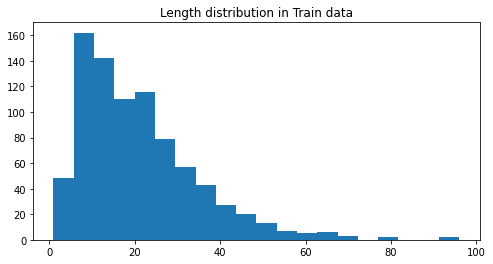

In [ ]:
length = map(lambda words_tags: len(words_tags[0]), train_data)

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

In [15]:
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def labels_transform(labels):
    return [tags_vocab.stoi[label] for label in labels]

def labels_inverse_transform(indices):
    return [tags_vocab.itos[label] for idx in indices]

def tokens_transform(tokens, lower=True):
    if lower:
        tokens = (token.lower() for token in tokens)
    return [words_vocab.stoi[token] for token in tokens]

def collate_batch(batch):
    labels_list, tokens_list = [], []
    for tokens, labels in batch:
        labels_indices = labels_transform(labels)
        labels_list.append(torch.tensor(labels_indices))
        tokens_indices = tokens_transform(tokens)
        tokens_list.append(torch.tensor(tokens_indices))
    return {
        "tokens": pad_sequence(tokens_list, batch_first=True, padding_value=PAD_IDX),
        "labels": pad_sequence(labels_list, batch_first=True, padding_value=PAD_IDX)
    }

BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

In [17]:
# посморим  на количество батчей
list(map(len, [train_loader, valid_loader, test_loader]))

[26, 4, 4]

### Модель и её обучение

Инициализируем нашу модель

In [18]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False, padding_idx=None, rnn_dropout=0, num_layers=1):
        super().__init__()
        
  
        self.embeddings = nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim, padding_idx=padding_idx)
        self.dropout = nn.Dropout(dropout)
        
        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, bidirectional=bidirectional, num_layers=num_layers, dropout=rnn_dropout, batch_first=True)
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        # не забываем применить dropout к embedding
        embedded = self.dropout(self.embeddings(sent))

        output, _ = self.rnn(embedded)
        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output)
    
        return prediction

In [19]:
# параметры модели
INPUT_DIM = len(words_vocab)
OUTPUT_DIM = len(tags_vocab)
EMB_DIM = 300
HID_DIM = 150
EMB_DROPOUT = 0.8
BIDIRECTIONAL = True
NUM_LAYERS = 1

model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, EMB_DROPOUT, num_layers=NUM_LAYERS).to(device)

Подсчитаем количество обучаемых параметров нашей модели

In [20]:
def count_parameters(model):
    return sum(map(lambda x: x.numel(), model.parameters()))

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,498,063 trainable parameters


Погнали обучать

In [21]:
def train(model, iterator, optimizer, criterion, clip, device, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        tokens = batch["tokens"].to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        
        output = model(tokens)
        
        #tags = [sent len, batch size]
        #output = [sent len, batch size, output dim]
        
        reshaped_output = output.view(-1, output.size(-1))
        reshaped_labels = labels.view(-1)
        
        #tags = [sent len * batch size]
        #output = [sent len * batch size, output dim]
        
        loss = criterion(reshaped_output, reshaped_labels)
        
        loss.backward()
        
        # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1) % 10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, device):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            tokens = batch["tokens"].to(device)
            labels = batch["labels"].to(device)

            output = model(tokens)

            #tags = [sent len, batch size]
            #output = [sent len, batch size, output dim]

            reshaped_output = output.view(-1, output.size(-1))
            reshaped_labels = labels.view(-1)

            #tags = [sent len * batch size]
            #output = [sent len * batch size, output dim]

            loss = criterion(reshaped_output, reshaped_labels)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
import math
import time

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch import optim

matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline

def train_valid_model(model, num_epochs, train_loader, valid_loader, optimizer, criterion, max_grad_norm, device):
    train_history = []
    valid_history = []
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        
        start_time = time.time()
        
        train_loss = train(model, train_loader, optimizer, criterion, max_grad_norm, device, train_history, valid_history)
        valid_loss = evaluate(model, valid_loader, criterion, device)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best-val-model.pt')

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [23]:
# параметры модели
INPUT_DIM = len(words_vocab)
OUTPUT_DIM = len(tags_vocab)
EMB_DIM = 300
HID_DIM = 50
EMB_DROPOUT = 0.5
BIDIRECTIONAL = True
NUM_LAYERS = 1

model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, EMB_DROPOUT, num_layers=NUM_LAYERS).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(4083, 300)
  (dropout): Dropout(p=0.8, inplace=False)
  (rnn): LSTM(300, 150, batch_first=True)
  (tag): Linear(in_features=150, out_features=13, bias=True)
)

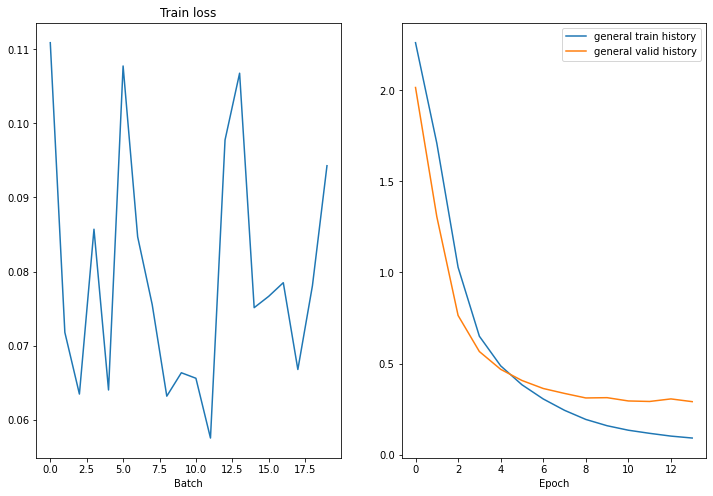

Epoch: 15 | Time: 0m 1s
	Train Loss: 0.075 | Train PPL:   1.078
	 Val. Loss: 0.282 |  Val. PPL:   1.325


In [107]:
model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, EMB_DROPOUT, BIDIRECTIONAL, PAD_IDX, num_layers=NUM_LAYERS).to(device)
model.apply(init_weights)
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

N_EPOCHS = 15
CLIP = 2

start_time = time.time()
train_valid_model(model, N_EPOCHS, train_loader, valid_loader, optimizer, criterion, CLIP, device)
training_time = time.time() - start_time

### Применение модели

In [24]:
def accuracy_model(model, iterator):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            tokens = batch["tokens"].to(device)
            labels = batch["labels"].to(device)

            output = model(tokens)
            
            predict_tags = output.argmax(dim=-1).cpu().numpy()
            true_tags = labels.cpu().numpy()

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
        
    return round(true_pred / num_pred * 100, 3)

In [109]:
print("Accuracy:", accuracy_model(model, test_loader), '%')

Accuracy: 90.872 %


Вы можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, вам неообходимо взять все выборку, а не только категорию `humor`.

In [25]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")

In [28]:
my_brown_tagged_sents = []

for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))

train_sents, test_sents = train_test_split(my_brown_tagged_sents, train_size=0.9, random_state=3)

start_time = time.time()
my_model = HiddenMarkovModel().fit(train_sents)
training_time = time.time() - start_time

start_time = time.time()
accuracy_score(my_model, test_sents)
testing_time = time.time() - start_time

100%|██████████| 5734/5734 [51:15<00:00,  1.86it/s]

Accuracy: 96.35753674901405 %


In [29]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
train_len = int(len(pos_data) * 0.8)
valid_len = int(len(pos_data) * 0.1)
test_len = len(pos_data) - (train_len + valid_len)
train_data, valid_data, test_data = random_split(pos_data, lengths=(train_len, valid_len, test_len))

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 45872
Number of validation examples: 5734
Number of testing examples: 5734


In [30]:
words_counter = Counter(chain.from_iterable(map(lambda w: w.lower(), words) for words, _ in train_data))
words_vocab = Vocab(words_counter, min_freq=1, specials=(PAD_TOKEN, UNK_TOKEN))

tags_counter = Counter(chain.from_iterable(tags for _, tags in train_data))
tags_vocab = Vocab(tags_counter, min_freq=1, specials=(PAD_TOKEN,))

assert words_vocab.stoi[PAD_TOKEN] == tags_vocab.stoi[PAD_TOKEN]
PAD_IDX = words_vocab.stoi[PAD_TOKEN]

print(f"Unique tokens in words vocabulary: {len(words_vocab)}")
print(f"Unique tokens in tags vocabulary: {len(tags_vocab)}")

Unique tokens in words vocabulary: 45067
Unique tokens in tags vocabulary: 13


In [31]:
BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

list(map(len, [train_loader, valid_loader, test_loader]))

[1433, 180, 180]

In [32]:
# параметры модели
INPUT_DIM = len(words_vocab)
OUTPUT_DIM = len(tags_vocab)
EMB_DIM = 300
HID_DIM = 150
EMB_DROPOUT = 0.8
BIDIRECTIONAL = True
NUM_LAYERS = 1

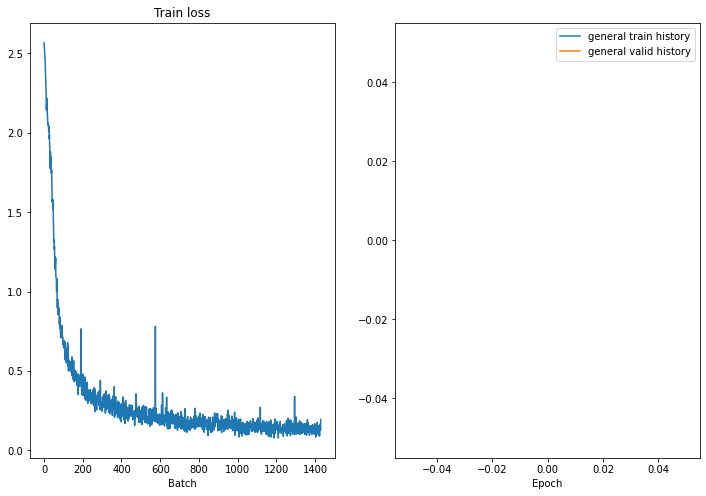

Epoch: 01 | Time: 11m 25s
	Train Loss: 0.305 | Train PPL:   1.357
	 Val. Loss: 0.103 |  Val. PPL:   1.108


In [33]:
model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, EMB_DROPOUT, BIDIRECTIONAL, PAD_IDX, num_layers=NUM_LAYERS).to(device)
model.apply(init_weights)
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

N_EPOCHS = 1
CLIP = 2

start_time = time.time()
train_valid_model(model, N_EPOCHS, train_loader, valid_loader, optimizer, criterion, CLIP, device)
training_time = time.time() - start_time

Вам неоходимо добиться качества не меньше, чем `accuracy = 93 %` 

In [34]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, EMB_DROPOUT, BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
assert accuracy_model(best_model, test_loader) >= 93

In [35]:
print("Accuracy:", accuracy_model(model, test_loader), '%')

Accuracy: 96.589 %


Пример решение нашей задачи:

In [36]:
@torch.no_grad()
def predict_tags_by_nn(model, sentence, device, batch_first=True, lower=True):
    model.eval()
    if lower:
        sentence = [word.lower() for word in sentence]
    example = torch.LongTensor(
        [words_vocab.stoi[word] for word in sentence]
    ).unsqueeze(0 if batch_first else 1).to(device)
    output = model(example)
    pred = output.argmax(dim=-1).squeeze(0 if batch_first else 1).cpu().numpy()
    tags = [tags_vocab.itos[elem] for elem in pred]
    return tags

def predict_tags_by_markov(model, sentence, lower=True):
    if lower:
        sentence = [word.lower() for word in sentence]
    return model.predict([sentence])[0]

def predict_tags(model, sentence, device=None, batch_first=True, lower=True):
    if isinstance(sentence, str):
        raise ValueError("sentence must be tokenized")
    if isinstance(sentence[0], str):
        words = sentence
    else:
        words, _ = sentence
    if isinstance(model, torch.nn.Module):
        if device is None:
            raise ValueError("device must be given when model is instance of torch.nn.Module")
        tags = predict_tags_by_nn(model, words, device, batch_first, lower)
    else:
        tags = predict_tags_by_markov(model, words, lower)
    return tags

In [37]:
def print_tags(model, sentence, device, batch_first=True):
    if isinstance(sentence, str):
        raise ValueError("sentence must be tokenized")
    if isinstance(sentence[0], str):
        words = sentence
    else:
        words, _ = sentence
    tags = predict_tags(model, sentence, device, batch_first)
    for token, tag in zip(words, tags):
        print(f'{token:15s}\t{tag}')

## Сравните результаты моделей HiddenMarkov, LstmTagger:
* при обучение на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе

Первое, время обучения и инференс. Скрытая марковская модель учится гораздо дольше, а её инференс вообще превышает разумные пределы. ОЕё обучение - запоминание распределений всей обучающей выборки, инференс — алгоритм Витерби — имеет линейную сложность от длины последовательности, но с достаточно большим коэффициентом (число тегов в квадрате), что даёт такое длительное время обучения. Нейронные сети с маленьким количеством тренировочных данных требуют несколько эпох обучения, но в целом учатся быстро, а инференс гораздо быстрее, чем у скрытой Марковской модели. На больших данных нейронные сети также показали себя и быстрее, и точнее.

Если судить по accuracy, качество разметки rnn выше, больше это ощущается, если сравнивать метрики Марковской модели и rnn на малых наборах данных. Мне кажется, что дропаут после эмбеддингов заставляет модель меньше полагаться на особенности слов и больше на их порядок, что, в принципе, очень логично. Особенно для английского языка. Из значений accuracy очевидна важность размера тренировочной выборки: обучение стабильнее и быстрее, качество результатов выше.

На большом датасете марковская модель подбирается близко к нейронке по accuracy. Причина, вероятно, в получении более близкого к реальному распределения вероятностей в матрицах переходов состояний.

Проведём еще такой эксперимент:

Возьмем предложение Владимира Набокова, переведённое на английский язык, из книги "The Gift". Предложение состоит из 64 слов и в нем определенно должны быть слова, которых не было в тренировочном датасете.

In [68]:
test_sentence = "As he crossed toward the pharmacy at the corner, he involuntarily" + \
 " turned his head because of a burst of light that had ricocheted from his temple," + \
 " and saw, with that quick smile with which we greet a rainbow or a rose, a blindingly" + \
 " white parallelogram of sky being unloaded from the dresser with mirrors across which," + \
 " as across a cinema screen, passed a flawlessly clear reflection of boughs sliding and swaying" + \
 " not arboreally, but with a human vacillation, produced by the nature of those who were carrying this sky," + \
 " these boughs, this gliding facade."

print_tags(model, test_sentence.split(), device)

As             	ADP
he             	PRON
crossed        	VERB
toward         	ADP
the            	DET
pharmacy       	NOUN
at             	ADP
the            	DET
corner,        	NOUN
he             	PRON
involuntarily  	VERB
turned         	VERB
his            	DET
head           	NOUN
because        	ADP
of             	ADP
a              	DET
burst          	NOUN
of             	ADP
light          	NOUN
that           	PRON
had            	VERB
ricocheted     	VERB
from           	ADP
his            	DET
temple,        	NOUN
and            	CONJ
saw,           	VERB
with           	ADP
that           	DET
quick          	ADJ
smile          	NOUN
with           	ADP
which          	DET
we             	PRON
greet          	VERB
a              	DET
rainbow        	NOUN
or             	CONJ
a              	DET
rose,          	VERB
a              	DET
blindingly     	ADJ
white          	ADJ
parallelogram  	NOUN
of             	ADP
sky            	NOUN
being          	VERB
unloaded       

In [69]:
print_tags(my_model, test_sentence.split(), device)

As             	ADP
he             	PRON
crossed        	VERB
toward         	ADP
the            	DET
pharmacy       	NOUN
at             	ADP
the            	DET
corner,        	NOUN
he             	PRON
involuntarily  	ADV
turned         	VERB
his            	DET
head           	NOUN
because        	ADP
of             	ADP
a              	DET
burst          	NOUN
of             	ADP
light          	NOUN
that           	PRON
had            	VERB
ricocheted     	VERB
from           	ADP
his            	DET
temple,        	NOUN
and            	CONJ
saw,           	NOUN
with           	ADP
that           	DET
quick          	ADJ
smile          	NOUN
with           	ADP
which          	DET
we             	PRON
greet          	VERB
a              	DET
rainbow        	NOUN
or             	CONJ
a              	DET
rose,          	NOUN
a              	DET
blindingly     	NOUN
white          	ADJ
parallelogram  	NOUN
of             	ADP
sky            	NOUN
being          	VERB
unloaded       

В данном примере предсказания моделей отличаются на involuntarily, rose, blindingly, mirrors, which, flawlessly, not, arboreally, gliding, facade.

На удивление, нейронная сеть не сомгла определить ни одного ADVERB, Марковская модель смогла определить один. Стоит отметить, что при этом всем оставшимся наречиям марковская модель присвоила тег NOUN, в то время, как нейронная сеть поняла, что это все-таки слово-описание, связанное с глаголом и присваивала им теги VERB и ADJECTIVE. Достаточно трудно судить, какая из моделей справилась лучше. 

Марковская модель также смогла определить верно rose и facade, но mirrors обе модели посчитали за VERB.

Обе модели показали себя не очень хорошо, но Марковская модель все-таки в данном случае справилась лучше.
Мои предположения, почему это могло произойти:
1. Предложение - абсолютно неестественное и художественное, с массой ранее невстречаемых слов
2. В тренировочных датасетах попросту мало предложений с больших количеством описаний предметов и действий. По этой причине модели ожидали после NOUN -> VERB, а получали между ними 1, а то и 2 ADVERBS.
3. Предложение хоть и большое, но почти везде идет правильный, обычный порядок слов. Марковская модель, на мой взгляд, лучше обрабатывает такие цепочки, какой бы они длины не были, т.к. они будут иметь наибольшую вероятность.

Трудно выделить модель, которая справляется лучше, но если взять во внимание инференс и обучение, то rnn по совокупности всех факторов лучше